# 전체 코드

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tf_agents.trajectories import time_step as ts

import absl
import time
import os
import glob

import pandas as pd
import numpy as np

import logging


# Generating dataset from csv file. Returns a Pandas DataFrame
def entire_dataset_from_single_file(filename,
                                    col_names,
                                    selected_col_names,
                                    remove_zero_req_prb_entries=True,
                                    scale_dl_buffer=True,
                                    replace_zero_with_one=False,
                                    add_prb_ratio=True):
    dataset = pd.read_csv(filename, names=col_names, usecols=selected_col_names, header=0)

    if remove_zero_req_prb_entries:
        dataset = dataset.loc[dataset['sum_requested_prbs'] > 0].reset_index(drop=True)

    if scale_dl_buffer and any(["dl_buffer [bytes]" in m for m in
                                selected_col_names]):
        # scale the dl_buffer
        dataset['dl_buffer [bytes]'] = dataset['dl_buffer [bytes]'] / 100000

    if add_prb_ratio:
        dict_add = pd.DataFrame.from_dict({"ratio_granted_req": np.clip(np.nan_to_num(
            dataset["sum_granted_prbs"] / dataset["sum_requested_prbs"]), a_min=0, a_max=1)
        })
        if replace_zero_with_one:
            dict_add['ratio_granted_req'].loc[dataset['sum_requested_prbs'] <= 0] = 1.0
        return dataset.join(dict_add)
    else:
        return dataset

# return all csv files inside a single DataFrame
def entire_dataset_from_folder(main_folder,
                               wildcard,
                               col_names,
                               selected_col_names,
                               scale_dl_buffer=True,
                               remove_zero_req_prb_entries=True,
                               replace_zero_with_one=False,
                               add_prb_ratio=True):
    dataset = []
    for filename in glob.glob(main_folder + wildcard):
        db_tmp = entire_dataset_from_single_file(filename, col_names=col_names,
                                                 selected_col_names=selected_col_names,
                                                 scale_dl_buffer=scale_dl_buffer,
                                                 remove_zero_req_prb_entries=remove_zero_req_prb_entries,
                                                 replace_zero_with_one=replace_zero_with_one,
                                                 add_prb_ratio=add_prb_ratio)
        dataset.append(db_tmp)

    return pd.concat(dataset, axis=0, ignore_index=True)


# take n entries from the DataFrame at random
def extract_n_entries_from_dataset(dataset=None,
                                   slice_id=None,
                                   n_entries=10,
                                   metrics_export=None):
    if slice_id is not None:
        d_temp = dataset.loc[dataset['slice_id'] == int(slice_id)]
    else:
        d_temp = dataset

    d_temp = d_temp.sample(n=n_entries).reset_index(drop=True)
    if metrics_export is not None:
        d_temp = d_temp[metrics_export]

    return d_temp

# This function is used here to emulate a DU reporting real-time data. Replace this function with your DU
# FOR TESTING PURPOSES ONLY
def get_data_from_DUs(dataset=None,
                      n_entries=1000,
                      n_col=4,
                      slice_id=None,
                      metrics_export=None):

    if dataset is None:  # generate random data in case you do not have a dataset
        values = np.random.random(size=(n_entries, n_col))
        slice_id = np.random.randint(low=0, high=3, size=(n_entries, 1))
        data = np.concatenate((slice_id, values), axis=1)
    else:
        data = extract_n_entries_from_dataset(dataset=dataset,
                                              slice_id=slice_id,
                                              n_entries=n_entries,
                                              metrics_export=metrics_export)

    return data


# Return lists for metrics, rewards, prbs assigned to each slice.
# Ideally, the list is such that len(list) = num_slices
def split_data(slice_profiles=None,
               data_to_spit=None,
               metric_list=None,
               metric_dict=None,
               n_entries_per_slice=None):
    metrics = []
    prbs = []
    rewards = []

    # ordering here follows slice_profiles
    for i in slice_profiles:

        slice_data = data_to_spit[data_to_spit[:, metric_dict['slice_id']] == slice_profiles[i]['slice_id'], :]

        if slice_data.size > 0:
            # repmat on rows to reach needed dimension in case you do not have enough reporting data
            while slice_data.shape[0] < n_entries_per_slice:
                slice_data = np.vstack((slice_data, np.zeros((1, slice_data.shape[1]))))

            slice_prb = slice_data[:, metric_dict['slice_prb']]
            slice_metrics = slice_data[:, [metric_dict[x] for x in metric_list]]
            slice_reward = slice_data[:, metric_dict[slice_profiles[i]['reward_metric']]]

            if n_entries_per_slice is not None:
                slice_prb = slice_prb[0:n_entries_per_slice]
                slice_metrics = slice_metrics[0:n_entries_per_slice, :]
                slice_reward = slice_reward[0:n_entries_per_slice]
        else:
            slice_metrics = []
            slice_prb = []
            slice_reward = []

        metrics.append(slice_metrics)
        prbs.append(slice_prb)
        rewards.append(slice_reward)

    return metrics, prbs, rewards

# Used to generate the input to the DRL agent. It returns a TimeStep that contains (step_type, reward, discount, observations)
def generate_timestep_for_policy(obs_tmp=None):
    step_type = tf.convert_to_tensor(
        [0], dtype=tf.int32, name='step_type')
    reward = tf.convert_to_tensor(
        [0], dtype=tf.float32, name='reward')
    discount = tf.convert_to_tensor(
        [1], dtype=tf.float32, name='discount')
    observations = tf.convert_to_tensor(
        [obs_tmp], dtype=tf.float32, name='observations')
    return ts.TimeStep(step_type, reward, discount, observations)


if __name__ == '__main__':

    # Column names in the srsLTE CSV dataset
    all_metrics_list = ["Timestamp",
                        "num_ues",
                        "IMSI",
                        "RNTI",
                        "empty_1",
                        "slicing_enabled",
                        "slice_id",
                        "slice_prb",
                        "power_multiplier",
                        "scheduling_policy",
                        "empty_2",
                        "dl_mcs",
                        "dl_n_samples",
                        "dl_buffer [bytes]",
                        "tx_brate downlink [Mbps]",
                        "tx_pkts downlink",
                        "tx_errors downlink (%)",
                        "dl_cqi",
                        "empty_3",
                        "ul_mcs",
                        "ul_n_samples",
                        "ul_buffer [bytes]",
                        "rx_brate uplink [Mbps]",
                        "rx_pkts uplink",
                        "rx_errors uplink (%)",
                        "ul_rssi",
                        "ul_sinr",
                        "phr",
                        "empty_4",
                        "sum_requested_prbs",
                        "sum_granted_prbs",
                        "empty_5",
                        "dl_pmi",
                        "dl_ri",
                        "ul_n",
                        "ul_turbo_iters"]

### 데이터를 모음
    # Column names we need to extract from the dataset
    metric_list_to_extract = ["slice_id",
                              "dl_buffer [bytes]",
                              "tx_brate downlink [Mbps]",
                              "sum_requested_prbs",
                              "sum_granted_prbs"]

    # configure logger and console output
    logging.basicConfig(level=logging.DEBUG, filename='./agent.log', filemode='a+',
                        format='%(asctime)-15s %(levelname)-8s %(message)s')
    formatter = logging.Formatter('%(asctime)-15s %(levelname)-8s %(message)s')
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(formatter)
    logging.getLogger('').addHandler(console)

    use_gpu_in_env = True
    mtc_policy_filename = './ml_models/mtc_policy'
    urllc_policy_filename = './ml_models/urllc_policy'
    embb_policy_filename = './ml_models/embb_policy'
    autoencoder_filename = './ml_models/encoder.h5'

    # Location of the dataset we want to use (valid in offline testing ONLY)
    main_folder = './slice_traffic/rome_static_close/tr10'
    wildcard_match = '/*/*/slices_bs*/*_metrics.csv'

    # get dataset for testing purposes only.
    # This is used as this code does not run with hardware components.
    # Not needed if getting data from real DUs
    dataset = entire_dataset_from_folder(main_folder=main_folder,
                                         wildcard=wildcard_match,
                                         col_names=all_metrics_list,
                                         selected_col_names=metric_list_to_extract)

    # Input size to the autoencoder for dimentionality reduction
    n_entries_for_autoencoder = 10

    # set logging level + enable TF2 behavior
    absl.logging.set_verbosity(absl.logging.INFO)
    # select which GPU to use
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    if use_gpu_in_env is False:
        gpu_devices = tf.config.experimental.list_physical_devices('GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print("Num GPUs Available outside environments: ", len(gpu_devices))

    # load policy, these are the folder where saved_model.pb is stored
    drl_agents = [tf.saved_model.load(embb_policy_filename),
                  tf.saved_model.load(mtc_policy_filename),
                  tf.saved_model.load(urllc_policy_filename)]

    absl.logging.info('Agents loaded')

    autoencoder = tf.keras.models.load_model(autoencoder_filename)

    absl.logging.info('Autoencoder loaded')

    slice_profiles = {'embb': {'slice_id': 0, 'reward_metric': "tx_brate downlink [Mbps]"},
                      'mtc': {'slice_id': 1, 'reward_metric': "tx_brate downlink [Mbps]"},
                      'urllc': {'slice_id': 2, 'reward_metric': "ratio_granted_req"}}

    metric_dict = {"dl_buffer [bytes]": 1,
                   "tx_brate downlink [Mbps]": 2,
                   "ratio_granted_req": 3,
                   "slice_id": 0,
                   "slice_prb": 4}

    metric_list_for_agents = ["dl_buffer [bytes]",
                   "tx_brate downlink [Mbps]",
                   "ratio_granted_req"]

    default_policy = 0
    previous_policy = dict()
    for _, val in slice_profiles.items():
        previous_policy[val['slice_id']] = default_policy

    previous_metrics = ''

    while True:
        policies = list()

        # This is where data comes from the DUs.
        # As an example, we extract data from the static dataset.
        # Users may want to interface it with their own DUs
        data = get_data_from_DUs(dataset=dataset,
                                 n_entries=1000,
                                 metrics_export=metric_list_to_extract).to_numpy()

        data_tmp, prbs, rewards = split_data(slice_profiles=slice_profiles,
                                             data_to_spit=data,
                                             metric_dict=metric_dict,
                                             metric_list=metric_list_for_agents,
                                             n_entries_per_slice=n_entries_for_autoencoder)

        for i in range(len(slice_profiles)):
            if len(data_tmp[i]) > 0:
                for row in data_tmp[i]:
                    row[0] /= 100000

                logging.info('Testing iteration ' + str(i))
                logging.info('Data received from DU (dl_buffer [bytes], tx_brate downlink [Mbps], ratio_granted_req): ')
                logging.info(np.expand_dims(data_tmp[i], axis=0))

                obs_tmp = autoencoder.predict(np.expand_dims(data_tmp[i], axis=0)).astype('float32')
                obs_tmp = np.append(obs_tmp, prbs[i][0]).astype('float32')

                reward_mean = np.mean(rewards[i]).astype('float32')
                time_step = generate_timestep_for_policy(obs_tmp)
                action = drl_agents[i].action(time_step)

                # append policies to send and store policy
                policies.append(action[0][0][0].numpy())
                previous_policy[i] = action[0][0][0].numpy()

                logging.info('Slice ' + str(i) + ': Action is ' + str(action[0][0][0].numpy()) + ' Reward is: ' + str(
                    reward_mean))
            else:
                # append previous policy
                policies.append(previous_policy[i])
                logging.info('Using previous action ' + str(previous_policy[i]) + ' for slice profile ' + str(i))

        # build message to send policies to the DU
        msg = ','.join([str(x) for x in policies])
        logging.info('Sending this message to the DU: ' + msg)

        time.sleep(10)

        # Users may want to plug in their own functions to send the DRL policies
        # to the DU based on the specific DU implementation in use
        # send_action_to_DU(DU_address, msg)


2023-04-17 20:47:40,902 INFO     Agents loaded


2023-04-17 20:47:40,997 WARNING  No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
2023-04-17 20:47:40,999 INFO     Autoencoder loaded
2023-04-17 20:47:41,007 INFO     Testing iteration 0
2023-04-17 20:47:41,007 INFO     Data received from DU (dl_buffer [bytes], tx_brate downlink [Mbps], ratio_granted_req): 
2023-04-17 20:47:41,007 INFO     [[[1.43300e-07 1.04877e+00 2.36000e+02]
  [1.91700e-07 1.21344e+00 2.35000e+02]
  [9.69000e-08 9.86208e-01 1.23000e+02]
  [1.76500e-07 9.84224e-01 6.46000e+02]
  [0.00000e+00 1.24886e+00 3.05000e+02]
  [4.50700e-07 8.88482e-01 3.90000e+02]
  [2.93000e-08 1.29928e+00 4.70000e+02]
  [0.00000e+00 9.70432e-01 4.09000e+02]
  [0.00000e+00 9.82265e-01 5.45000e+02]
  [2.97000e-08 1.05568e+00 6.85000e+02]]]


1/1 [==============================] - 0s 139ms/step


2023-04-17 20:47:41,238 INFO     Slice 0: Action is 1 Reward is: 1.067764
2023-04-17 20:47:41,240 INFO     Testing iteration 1
2023-04-17 20:47:41,240 INFO     Data received from DU (dl_buffer [bytes], tx_brate downlink [Mbps], ratio_granted_req): 
2023-04-17 20:47:41,241 INFO     [[[3.70000e-09 2.27149e-02 4.10000e+01]
  [0.00000e+00 1.07520e-02 2.40000e+01]
  [0.00000e+00 5.13600e-02 3.17000e+02]
  [0.00000e+00 4.28800e-02 1.41000e+02]
  [1.07000e-08 3.46667e-02 4.70000e+01]
  [0.00000e+00 4.26667e-02 1.24000e+02]
  [1.13000e-08 4.45760e-02 3.40000e+02]
  [0.00000e+00 6.52530e-02 7.80000e+01]
  [0.00000e+00 4.27200e-02 5.50000e+01]
  [0.00000e+00 3.19680e-02 6.70000e+01]]]


1/1 [==============================] - 0s 14ms/step


2023-04-17 20:47:41,308 INFO     Slice 1: Action is 1 Reward is: 0.03895573
2023-04-17 20:47:41,309 INFO     Testing iteration 2
2023-04-17 20:47:41,309 INFO     Data received from DU (dl_buffer [bytes], tx_brate downlink [Mbps], ratio_granted_req): 
2023-04-17 20:47:41,310 INFO     [[[0.00000e+00 1.60000e-02 1.20000e+01]
  [0.00000e+00 2.11200e-02 3.00000e+01]
  [0.00000e+00 1.76640e-02 8.30000e+01]
  [0.00000e+00 5.31200e-03 4.00000e+00]
  [0.00000e+00 1.60000e-02 2.00000e+01]
  [0.00000e+00 5.31200e-03 6.00000e+00]
  [0.00000e+00 1.63534e-02 9.00000e+00]
  [0.00000e+00 2.17189e-02 5.00000e+01]
  [0.00000e+00 5.31200e-03 4.00000e+00]
  [0.00000e+00 1.13280e-02 5.70000e+01]]]


1/1 [==============================] - 0s 16ms/step


2023-04-17 20:47:41,379 INFO     Slice 2: Action is 2 Reward is: 27.5
2023-04-17 20:47:41,380 INFO     Sending this message to the DU: 1,1,2


KeyboardInterrupt: 

# 파일 읽기

## encoder.h5

In [1]:
import h5py

# file import
encoder = h5py.File('./ml_models/encoder.h5', 'r')

# encoder (0)
indent = 0
print(f"{' '*4*indent}---encoder-----------------")
print(f"encoder : {list(encoder.keys())}")
print('')

# model_weights (1)
indent = 1
print(f"{' '*4*indent}---model_weights-----------------")
print(f"{' '*4*indent}model_weights : {list(encoder['model_weights'].keys())}")
print('')

dense = ['model_weights/dense_'+str(i)+'/dense_'+str(i) for i in range(5)]
dense[0] = 'model_weights/dense/dense'
bias = [dense[i]+'/bias:0' for i in range(5)]
kernel = [dense[i]+'/kernel:0' for i in range(5)]

# dense (2)
indent = 2
for i in range(4):
    if i == 0:
        print(f"{' '*4*indent}---dense-----------------")
        print(f"{' '*4*indent}dense :{list(encoder[dense[i]].keys())}")
    else:
        print(f"{' '*4*indent}---dense_{str(i)}-----------------")
        print(f"{' '*4*indent}dense_{str(i)} : {list(encoder[dense[i]].keys())}")
    print(f"{' '*4*indent}{bias[i]} : {encoder[bias[i]][:].shape}") #\n{encoder[bias[i]][:]}")
    print(f"{' '*4*indent}{kernel[i]} : {encoder[kernel[i]][:].shape}") #\n{encoder[kernel[i]][:]}")
    print('')

# flatten (2)
indent = 2
print(f"{' '*4*indent}---flatten-----------------")
print(f"{' '*4*indent}flatten : {list(encoder['model_weights/flatten'].keys())}")

---encoder-----------------
encoder : ['model_weights']

    ---model_weights-----------------
    model_weights : ['dense', 'dense_1', 'dense_2', 'dense_3', 'flatten']

        ---dense-----------------
        dense :['bias:0', 'kernel:0']
        model_weights/dense/dense/bias:0 : (256,)
        model_weights/dense/dense/kernel:0 : (30, 256)

        ---dense_1-----------------
        dense_1 : ['bias:0', 'kernel:0']
        model_weights/dense_1/dense_1/bias:0 : (128,)
        model_weights/dense_1/dense_1/kernel:0 : (256, 128)

        ---dense_2-----------------
        dense_2 : ['bias:0', 'kernel:0']
        model_weights/dense_2/dense_2/bias:0 : (32,)
        model_weights/dense_2/dense_2/kernel:0 : (128, 32)

        ---dense_3-----------------
        dense_3 : ['bias:0', 'kernel:0']
        model_weights/dense_3/dense_3/bias:0 : (3,)
        model_weights/dense_3/dense_3/kernel:0 : (32, 3)

        ---flatten-----------------
        flatten : []


## .csv

In [ ]:
import pandas as pd
import glob
import os
import glob

import pandas as pd
import numpy as np

main_folder = './slice_traffic/rome_static_close/tr10'
wildcard_match = '/*/*/slices_bs*/*_metrics.csv'

# get all files in the folder
for filename in glob.glob(main_folder + wildcard_match):
    #print(filename)
    data = pd.read_csv(filename)
    
    #print(data.columns)
    print(f"------------------ {filename} ------------------")
    print(data[['slice_id','tx_brate downlink [Mbps]']])
    print(data.info())
    print('')
    if len(data) >= 1819:
        break



In [74]:
import pandas as pd
import glob
import os

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
def entire_dataset_from_single_file(filename,
                                    col_names,
                                    selected_col_names,
                                    remove_zero_req_prb_entries=True,
                                    scale_dl_buffer=True,
                                    replace_zero_with_one=False,
                                    add_prb_ratio=True):
    dataset = pd.read_csv(filename, names=col_names, usecols=selected_col_names, header=0)

    if remove_zero_req_prb_entries:
        dataset = dataset.loc[dataset['sum_requested_prbs'] > 0].reset_index(drop=True)

    if scale_dl_buffer and any(["dl_buffer [bytes]" in m for m in
                                selected_col_names]):
        # scale the dl_buffer
        dataset['dl_buffer [bytes]'] = dataset['dl_buffer [bytes]'] / 100000

    if add_prb_ratio:
        dict_add = pd.DataFrame.from_dict({"ratio_granted_req": np.clip(np.nan_to_num(
            dataset["sum_granted_prbs"] / dataset["sum_requested_prbs"]), a_min=0, a_max=1)
        })
        if replace_zero_with_one:
            dict_add['ratio_granted_req'].loc[dataset['sum_requested_prbs'] <= 0] = 1.0
        return dataset.join(dict_add)
    else:
        return dataset

def entire_dataset_from_folder(main_folder,
                               wildcard,
                               col_names,
                               selected_col_names,
                               scale_dl_buffer=True,
                               remove_zero_req_prb_entries=True,
                               replace_zero_with_one=False,
                               add_prb_ratio=True):
    dataset = []
    for filename in glob.glob(main_folder + wildcard):
        db_tmp = entire_dataset_from_single_file(filename, col_names=col_names,
                                                 selected_col_names=selected_col_names,
                                                 scale_dl_buffer=scale_dl_buffer,
                                                 remove_zero_req_prb_entries=remove_zero_req_prb_entries,
                                                 replace_zero_with_one=replace_zero_with_one,
                                                 add_prb_ratio=add_prb_ratio)
        dataset.append(db_tmp)

    return pd.concat(dataset, axis=0, ignore_index=True)

main_folder = './slice_traffic/rome_static_close/tr10'
wildcard_match = '/*/*/slices_bs*/*_metrics.csv'

# metric_list_to_extract = ["slice_id",
#                           "dl_buffer [bytes]",
#                           "tx_brate downlink [Mbps]",
#                           "sum_requested_prbs",
#                           "sum_granted_prbs"]

all_metrics_list = ["Timestamp",
                    "num_ues",
                    "IMSI",
                    "RNTI",
                    "empty_1",
                    "slicing_enabled",
                    "slice_id",
                    "slice_prb",
                    "power_multiplier",
                    "scheduling_policy",
                    "empty_2",
                    "dl_mcs",
                    "dl_n_samples",
                    "dl_buffer [bytes]",
                    "tx_brate downlink [Mbps]",
                    "tx_pkts downlink",
                    "tx_errors downlink (%)",
                    "dl_cqi",
                    "empty_3",
                    "ul_mcs",
                    "ul_n_samples",
                    "ul_buffer [bytes]",
                    "rx_brate uplink [Mbps]",
                    "rx_pkts uplink",
                    "rx_errors uplink (%)",
                    "ul_rssi",
                    "ul_sinr",
                    "phr",
                    "empty_4",
                    "sum_requested_prbs",
                    "sum_granted_prbs",
                    "empty_5",
                    "dl_pmi",
                    "dl_ri",
                    "ul_n",
                    "ul_turbo_iters"]

dataset = entire_dataset_from_folder(main_folder=main_folder,
                                     wildcard=wildcard_match,
                                     col_names=all_metrics_list,
                                     selected_col_names=all_metrics_list)

if dataset.isnull().values.any() or dataset.isna().values.any():
    print("Warning: there are still NaN or NA values in the dataset!")

if dataset['slice_id'] is not None:
    dataset['slice_id'].replace({0:'embb', 1:'mtc', 2:'urllc'}, inplace=True)
    dataset['slice_id'] = dataset['slice_id'].astype('category')
print(dataset.cat.categories)
# drop columns
dataset.drop(["Timestamp",
              "num_ues",
              "empty_1",
              "slicing_enabled",
              "slice_id",
              "slice_prb",
              "power_multiplier",
              "scheduling_policy",
              "empty_2",
              "tx_errors downlink (%)",
              "empty_3",
              "ul_rssi",
              "empty_4",
              "empty_5",
              "dl_pmi",
              "dl_ri",
              "ul_n",
              "sum_requested_prbs",
              "sum_granted_prbs"],
             axis=1, inplace=True)

dataset.to_csv('./entire_dataset.csv', index=False)
dataset.info()

AttributeError: 'DataFrame' object has no attribute 'cat'

## Corr

In [137]:
dataset.head()

,IMSI,RNTI,dl_mcs,dl_n_samples,dl_buffer [bytes],tx_brate downlink [Mbps],tx_pkts downlink,dl_cqi,ul_mcs,ul_n_samples,ul_buffer [bytes],rx_brate uplink [Mbps],rx_pkts uplink,rx_errors uplink (%),ul_sinr,phr,ul_turbo_iters,ratio_granted_req
0,1010123456002,74,5.17391,23,0.0,0.015072,10,6.00,13.7308,26,0,0.1,10,50.0,12.46060,31,5.65385,1.000000
1,1010123456002,74,16.18750,16,0.0,0.015872,6,12.00,0.0000,0,0,0.0,0,0.0,0.00000,0,0.00000,0.777778
2,1010123456002,74,3.82222,90,0.0,0.035264,36,9.75,0.0000,0,0,0.0,0,0.0,0.00000,0,0.00000,0.951351
3,1010123456002,74,17.09520,21,0.0,0.015968,6,9.60,0.1000,3,0,0.1,1,0.0,4.47455,31,1.00000,0.833333
4,1010123456002,74,15.11110,9,0.0,0.015872,6,13.00,0.1000,20,0,0.1,9,0.0,4.12881,0,1.00000,1.000000


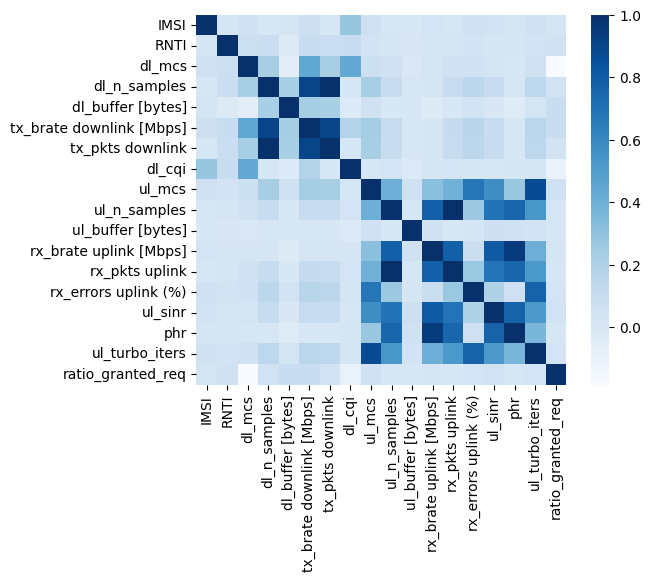

In [138]:
corr = dataset.corr(method = 'pearson')
df_heatmap = sns.heatmap(corr, cbar = True, annot = False, annot_kws={'size' : 10}, 
                         fmt = '.2f', square = True, cmap = 'Blues')

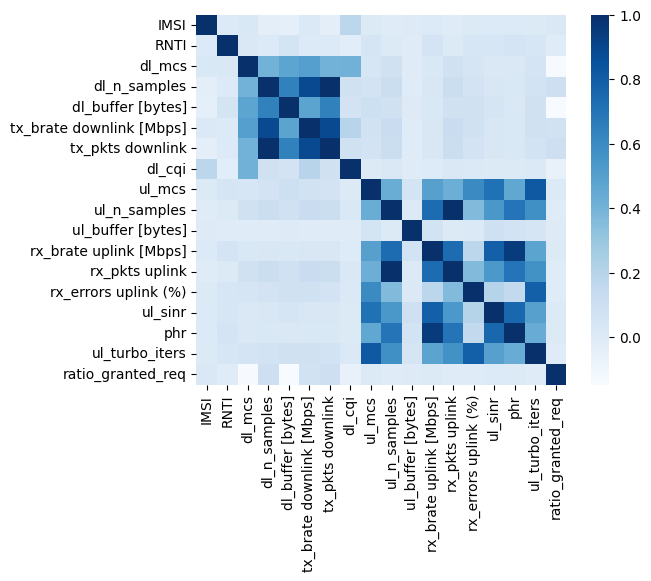

In [128]:
corr = dataset.corr(method = 'pearson')
corr
df_heatmap = sns.heatmap(corr, cbar = True, annot = False, annot_kws={'size' : 10}, 
                         fmt = '.2f', square = True, cmap = 'Blues')